# Exocomet search

```{warning}
Under construction
```

In [1]:
# in order to run on all CPUs
import os

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

In [2]:
import lightkurve as lk
import numpy as np

# single sector
lc = lk.search_lightcurve("beta pic", author="SPOC", exptime=120)[5].download()

# masking nans
time = lc.time.to_value("btjd")
flux = lc.pdcsap_flux.to_value().filled(np.nan)
error = lc.flux_err.to_value().filled(np.nan)
mask = np.isnan(flux) | np.isnan(error) | np.isnan(time)

# we only want to analyze the first 3000 points
# mask[time < 1423] = True
time = time[~mask].astype(float)
flux = flux[~mask].astype(float)
error = error[~mask].astype(float)

# normalize
flux_median = np.median(flux)
flux /= flux_median
error /= flux_median

/opt/homebrew/Caskroom/miniforge/base/envs/nuance/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/lgrcia/.lightkurve/cache. Please move all the files in the legacy directory /Users/lgrcia/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [3]:
lc.sector

33

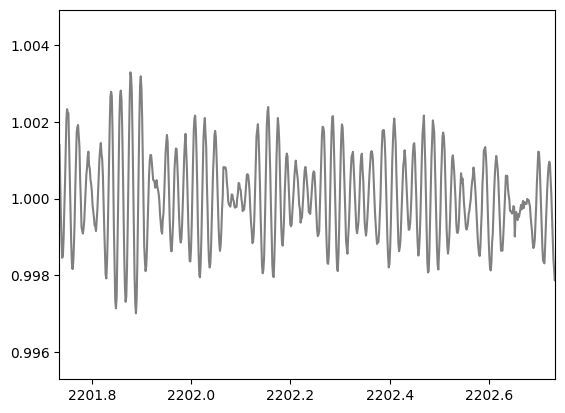

In [4]:
import matplotlib.pyplot as plt

plt.plot(time, flux, c="0.5", label="raw data")
_ = plt.xlim(time.min(), time.min() + 1)

In [5]:
def rotation_period(time, flux):
    """rotation period based on LS periodogram"""
    from astropy.timeseries import LombScargle

    ls = LombScargle(time, flux)
    frequency, power = ls.autopower(
        minimum_frequency=1 / 10, maximum_frequency=1 / 0.01
    )
    period = 1 / frequency[np.argmax(power)]
    return period


period = 0.5  # rotation_period(time, flux)
print(f"P = {period:.3f} days")

P = 0.500 days


## Gaussian Process

In [6]:
import jax.numpy as jnp
from nuance.kernels import Rotation
from tinygp import GaussianProcess, kernels

initial_params = {
    "log_period": jnp.log(0.5),
    "log_Q": jnp.log(100),
    "log_sigma": jnp.log(jnp.std(flux)),
    "log_dQ": jnp.log(100),
    "log_f": jnp.log(2.0),
    "log_jitter": jnp.log(jnp.mean(error)),
}


def build_gp(params, time, mean=0.0):
    jitter2 = jnp.exp(2 * params["log_jitter"])

    kernel = Rotation(
        jnp.exp(params["log_sigma"]),
        jnp.exp(params["log_period"]),
        jnp.exp(params["log_Q"]),
        jnp.exp(params["log_dQ"]),
        jnp.exp(params["log_f"]),
    )
    return GaussianProcess(kernel, time, diag=jitter2, mean=mean)

/opt/homebrew/Caskroom/miniforge/base/envs/nuance/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from nuance.utils import minimize
from nuance.core import gp_model

mu, nll = gp_model(time, flux, build_gp)

# optimization
gp_params = minimize(nll, initial_params, ["log_sigma"])
gp_params = minimize(nll, gp_params)

Let's see the cleaned light curve

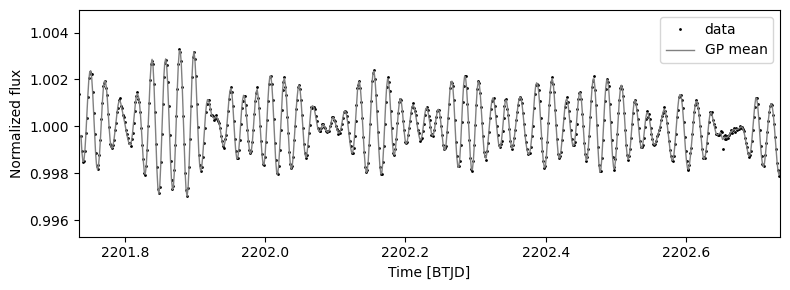

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(time, flux, ".", c="k", ms=2, label="data")

gp_mean = mu(gp_params)
split_idxs = [
    0,
    *np.flatnonzero(np.diff(time) > 10 / 60 / 24),
    len(time),
]

_ = True
for i in range(len(split_idxs) - 1):
    x = time[split_idxs[i] + 1 : split_idxs[i + 1]]
    y = gp_mean[split_idxs[i] + 1 : split_idxs[i + 1]]
    plt.plot(x, y, "0.5", label="GP mean" if _ else None, lw=1)
    _ = False

plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized flux")
plt.legend()
plt.tight_layout()
_ = plt.xlim(time.min(), time.min() + 1)

## Exocomet search

All the above is data preparation, now is time to actually search the cleaned light curve


### The model

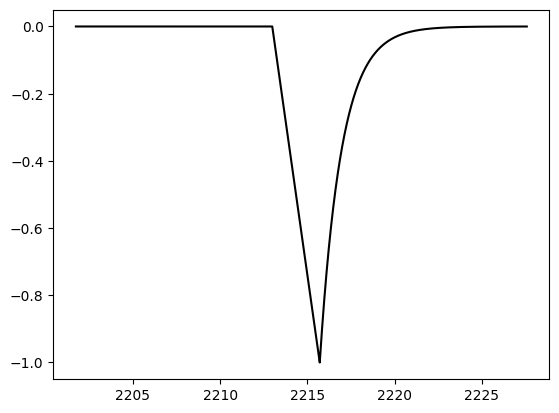

In [9]:
import jax.numpy as jnp
import matplotlib.pyplot as plt


def exocomet(time, t0, duration, P=None, n=3):
    flat = jnp.zeros_like(time)
    left = -(time - (t0 - duration / n)) / (duration / n)
    right = -jnp.exp(-2 / duration * (time - t0 - duration / n)) ** 2
    triangle = jnp.maximum(left, right)
    mask = time >= t0 - duration / n
    signal = jnp.where(mask, triangle, flat)
    return signal / jnp.max(jnp.array([-jnp.min(signal), 1]))


plt.plot(time, exocomet(time, np.mean(time), 5), c="k")

In [10]:
from nuance import Nuance

t0s = time.copy()
Ds = np.linspace(1 / 24, 1.5, 20)

gp = build_gp(gp_params, time)
nu = Nuance(time, flux, gp=gp, model=exocomet)
nu.linear_search(t0s, Ds)

100%|██████████| 17460/17460 [00:50<00:00, 347.58it/s]


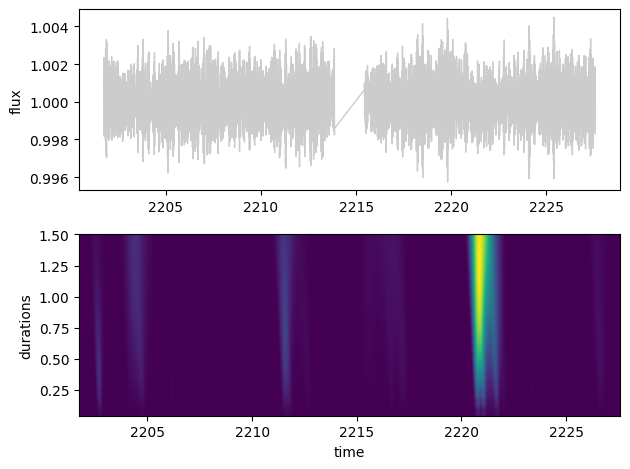

In [11]:
plt.subplot(211)
plt.plot(time, flux, c="0.8", lw=1)
plt.ylabel("flux")

plt.subplot(212)
nu.search_data.show_ll()
plt.ylabel("durations")
plt.xlabel("time")

plt.tight_layout()

In [12]:
from tqdm import tqdm

snrs = np.array(
    [nu.snr(t0, Ds[np.argmax(nu.search_data.ll[i])]) for i, t0 in enumerate(tqdm(t0s))]
)

100%|██████████| 17458/17458 [00:26<00:00, 652.90it/s]


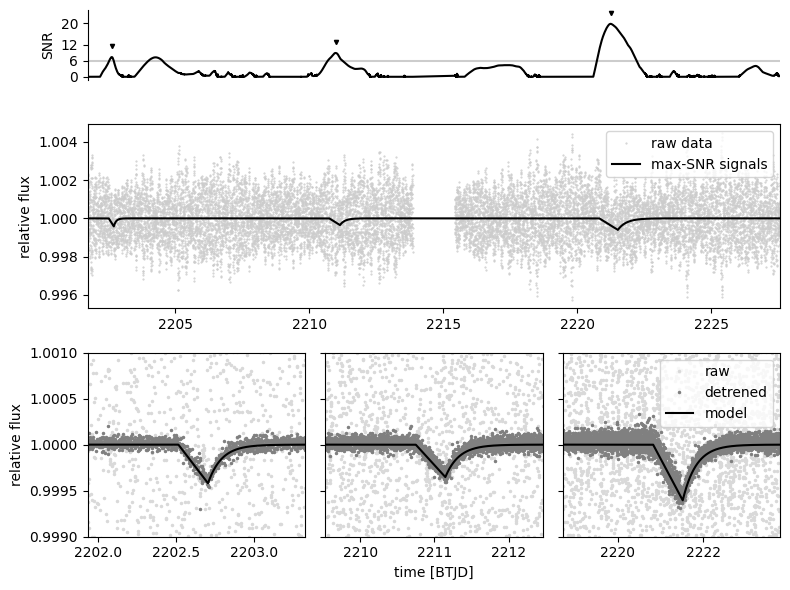

In [13]:
plt.figure(figsize=(8, 6))

xmin, xmax = 1410, 1415

ms = 3

i, j = np.unravel_index(np.argmax(nu.search_data.ll), nu.search_data.ll.shape)
t0, D = nu.search_data.t0s[i], nu.search_data.Ds[j]
linear, astro, noise = nu.models(t0, D)
# plt.figure(figsize=(8, 3))
n = 5
min_snr = 6
ax = plt.subplot(n, 3, (1, 3))
ax.plot(time, snrs, "-", c="k")
ax.axhline(min_snr, c="k", alpha=0.2)
# remove x axis and spine
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks([])
ax.set_yticks([0, min_snr, 12, 20])
ax.set_xlim(time.min(), time.max())
ax.set_ylabel("SNR")

from scipy.signal import find_peaks

peaks, _ = find_peaks(snrs, height=min_snr, distance=0.5 / np.diff(time).mean())
peaks = peaks[np.argsort(snrs[peaks])[::-1]][0:3]
peaks = peaks[np.argsort(time[peaks])]
ax.plot(time[peaks], snrs[peaks] + 4, "v", c="k", ms=ms)

plt.subplot(n, 3, (4, 9))

signals = []
for peak in peaks:
    t0 = t0s[peak]
    j = np.argmax(nu.search_data.ll[peak])
    D = nu.search_data.Ds[j]
    linear, astro, noise = nu.models(t0, D)
    signals.append(astro)
signals = np.min(signals, axis=0) + 1.0

plt.plot(time, flux, ".", c="0.8", ms=1, label="raw data")
plt.plot(time, signals, "k", label="max-SNR signals")
plt.xlim(time.min(), time.max())
plt.ylabel("relative flux")
plt.legend(loc="upper right")

for i, peak in enumerate(peaks):
    ax = plt.subplot(n, 3, (10 + i, 13 + i))
    t0 = t0s[peak]
    j = np.argmax(nu.search_data.ll[peak])
    D = nu.search_data.Ds[j]
    linear, astro, noise = nu.models(t0, D)
    plt.plot(time, flux, ".", c="0.85", ms=ms, label="raw" if i == 2 else None)
    plt.plot(
        time,
        flux - noise,
        ".",
        c="0.5",
        ms=ms,
        label="detrened" if i == 2 else None,
    )
    plt.plot(time, astro + 1, c="k", label="model" if i == 2 else None)
    xmin, xmax = t0 + 2 * np.array([-1, 1]) * D
    plt.xlim(xmin, xmax)
    plt.ylim(0.999, 1.001)
    plt.plot(nu.search_data.Ds, nu.search_data.ll[peak], c="k")
    if i != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("relative flux")
    if i == 1:
        ax.set_xlabel("time [BTJD]")
    if i == 2:
        ax.legend(loc="upper right")

plt.tight_layout()
# plt.savefig("exocomet.pdf")